### Code: Ground-Based Cloud Type Classification for Aviation Weather Hazard Detection Using Deep Learning
#### Marcus P. Cote, Michael E. Splitt, Steven M. Lazarus, Ryan T. White, and Cecilia G. Baker

### 1) Computer Hardware Allocation

In [1]:
import torch
print(torch.__version__)

##For MAC M1 Silicon:
# Is MPS even available? macOS 12.3+
print(torch.backends.mps.is_available())
# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

## Check if a GPU is available:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("apple silicon")
else:
    device = torch.device("cpu")
    print("no silicon, no cuda")
torch.cuda.empty_cache()

2.5.0+cu121
False
False
cuda


### 2) Training Experiments
*Note: Due to some technical complications (e.g., unplanned computer sleeping), not all training runtimes are accurate.
#### I. ResNet-50
##### a) Model Summary

In [10]:
from torchsummary import summary
from torchvision import models
from torchvision.models import ResNet50_Weights

# Load ResNet-50 model pre-trained on ImageNet
model = models.resnet50(weights=ResNet50_Weights.DEFAULT).to("cpu")

# Modify the final dense layer for 9 classes
num_classes = 9
in_features = model.fc.in_features  # Get the input features of the final layer
model.fc = torch.nn.Linear(in_features, num_classes).to("cpu")  # Replace final layer with 9 output classes

# Print model summary
summary(model, input_size=(3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

##### b) Data Loading and Preprocessing

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os
from torchvision.datasets.utils import download_and_extract_archive


data_dir=""

# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the validation transform (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the training and validation datasets using ImageFolder with their respective transforms
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train/'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val/'), transform=val_transform)

# Load the data in batches using DataLoader (shuffle training set)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Verify the dataset structure
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

Classes: ['ac', 'cb', 'ci', 'clear', 'cu', 'obscured', 'precip', 'st', 'tcu']
Training set size: 12436, Validation set size: 3107


##### c) Model training

In [5]:
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F

# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='prelim_resnet-50.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# ResNet-50 Model for transfer learning
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=9):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Replace the final fully connected layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = ResNet50Model(num_classes=9).to(device)  # Adjust num_classes for training data
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # Compute loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            loss = criterion(outputs, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('prelim_resnet-50.pt', weights_only=True))

Epoch 1/100
Train Loss: 0.4448, Train Accuracy: 85.86%
Val Loss: 0.2268, Val Accuracy: 92.40%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 0.0867, Train Accuracy: 97.19%
Val Loss: 0.1989, Val Accuracy: 94.43%
Validation loss decreased. Saving model ...
------------------------------
Epoch 3/100
Train Loss: 0.0464, Train Accuracy: 98.69%
Val Loss: 0.1859, Val Accuracy: 94.43%
Validation loss decreased. Saving model ...
------------------------------
Epoch 4/100
Train Loss: 0.0387, Train Accuracy: 98.77%
Val Loss: 0.2000, Val Accuracy: 93.76%
Validation loss did not improve. EarlyStopping counter: 1 out of 10
------------------------------
Epoch 5/100
Train Loss: 0.0267, Train Accuracy: 99.28%
Val Loss: 0.1933, Val Accuracy: 95.14%
Validation loss did not improve. EarlyStopping counter: 2 out of 10
------------------------------
Epoch 6/100
Train Loss: 0.0216, Train Accuracy: 99.36%
Val Loss: 0.2532, Val Accuracy: 94.66%
Validation lo

<All keys matched successfully>

#### II. Xception
##### a) Model Summary

In [45]:
import torch
from torchsummary import summary
import timm  # Install via `pip install timm`

# Load Xception model pre-trained on ImageNet
model = timm.create_model('xception', pretrained=True).to("cpu")

# Modify the final dense layer for 9 classes
num_classes = 9
in_features = model.fc.in_features  # Get the input features of the final layer
model.fc = torch.nn.Linear(in_features, num_classes).to("cpu")  # Replace final layer with 9 output classes

# Print model summary
summary(model, input_size=(3, 299, 299), device="cpu")

/Users/mcote2021/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mcote2021/anaconda3/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /Users/mcote2021/.cache/torch/hub/checkpoints/xception-43020ad28.pth


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 64, 147, 147]          18,432
       BatchNorm2d-5         [-1, 64, 147, 147]             128
              ReLU-6         [-1, 64, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]             576
            Conv2d-8        [-1, 128, 147, 147]           8,192
   SeparableConv2d-9        [-1, 128, 147, 147]               0
      BatchNorm2d-10        [-1, 128, 147, 147]             256
             ReLU-11        [-1, 128, 147, 147]               0
           Conv2d-12        [-1, 128, 147, 147]           1,152
           Conv2d-13        [-1, 128, 147, 147]          16,384
  SeparableConv2d-14        [-1, 128, 1

##### b) Data Loading and Preprocessing

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os
from torchvision.datasets.utils import download_and_extract_archive


data_dir=""

# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the validation transform (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the training and validation datasets using ImageFolder with their respective transforms
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train/'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val/'), transform=val_transform)

# Load the data in batches using DataLoader (shuffle training set)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Verify the dataset structure
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

Classes: ['ac', 'cb', 'ci', 'clear', 'cu', 'obscured', 'precip', 'st', 'tcu']
Training set size: 12436, Validation set size: 3107


##### c) Model Training

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import timm  # Install via `pip install timm`
import torch.nn.functional as F

# EarlyStopping class definition (unchanged)
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='prelim_xception.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# Xception Model for transfer learning using timm
class XceptionModel(nn.Module):
    def __init__(self, num_classes=9):
        super(XceptionModel, self).__init__()
        self.model = timm.create_model('xception', pretrained=True)  # Load Xception
        in_features = self.model.fc.in_features  # Get the number of features in the last layer
        self.model.fc = nn.Linear(in_features, num_classes)  # Replace with custom output layer

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = XceptionModel(num_classes=9).to(device)  # Adjust num_classes for your dataset
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # Compute loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            loss = criterion(outputs, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('prelim_xception.pt', weights_only=True))

/Users/mcote2021/anaconda3/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/100
Train Loss: 0.4073, Train Accuracy: 88.45%
Val Loss: 0.1961, Val Accuracy: 93.76%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 0.0644, Train Accuracy: 98.21%
Val Loss: 0.1667, Val Accuracy: 94.63%
Validation loss decreased. Saving model ...
------------------------------
Epoch 3/100
Train Loss: 0.0333, Train Accuracy: 99.10%
Val Loss: 0.1608, Val Accuracy: 95.59%
Validation loss decreased. Saving model ...
------------------------------
Epoch 4/100
Train Loss: 0.0178, Train Accuracy: 99.49%
Val Loss: 0.1800, Val Accuracy: 95.01%
Validation loss did not improve. EarlyStopping counter: 1 out of 10
------------------------------
Epoch 5/100
Train Loss: 0.0196, Train Accuracy: 99.36%
Val Loss: 0.1950, Val Accuracy: 94.85%
Validation loss did not improve. EarlyStopping counter: 2 out of 10
------------------------------
Epoch 6/100
Train Loss: 0.0145, Train Accuracy: 99.57%
Val Loss: 0.1732, Val Accuracy: 95.14%
Validation lo

<All keys matched successfully>

#### III. Inception-v3
##### a) Model Summary

In [294]:
import torch
from torchsummary import summary
from torchvision import models
from torchvision.models import Inception_V3_Weights

# Load InceptionV3 model pre-trained on ImageNet
model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT).to("cpu")

# Modify the final dense layer for 10 classes
num_classes = 9
in_features = model.fc.in_features  # Get the input features of the final layer
model.fc = torch.nn.Linear(in_features, num_classes).to("cpu")  # Replace final layer with 9 output classes

# Print model summary
summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

##### b) Data Loading and Preprocessing  (Batch size edited here for Experiments 1-5)

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os
from torchvision.datasets.utils import download_and_extract_archive


data_dir="webcam_v1"

# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the validation transform (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the training and validation datasets using ImageFolder with their respective transforms
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train/'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val/'), transform=val_transform)

# Load the data in batches using DataLoader (shuffle training set)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Verify the dataset structure
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

Classes: ['ac', 'cb', 'ci', 'clear', 'cu', 'obscured', 'precip', 'st', 'tcu']
Training set size: 12436, Validation set size: 3107


##### c) Model Training
##### Experiment 1 (preliminary expierment): See manuscript for details

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models, transforms
import torch.nn.functional as F

# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='inception-v3_1.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# Inception v3 Model for transfer learning
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

        # Replace the final fully connected layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = InceptionV3Model(num_classes=9).to(device)  # Adjust num_classes for training data
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass - Inception v3 returns two outputs: the main output and auxiliary output
        outputs = net(inputs)
        if isinstance(outputs, models.inception.InceptionOutputs):
            main_output, aux_output = outputs.logits, outputs.aux_logits
            # Compute loss using both main and auxiliary outputs
            loss = criterion(main_output, labels) + 0.4 * criterion(aux_output, labels)  # Weight auxiliary loss
        else:
            loss = criterion(outputs, labels)  # For validation, when there is no aux output
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(main_output, 1)  # Use main output for accuracy calculation
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            if isinstance(outputs, models.inception.InceptionOutputs):
                main_output = outputs.logits  # Only use the main output for validation
            else:
                main_output = outputs
            
            loss = criterion(main_output, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(main_output, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('inception-v3_1.pt'))

Epoch 1/100
Train Loss: 0.5803, Train Accuracy: 88.56%
Val Loss: 0.2239, Val Accuracy: 92.63%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 0.1273, Train Accuracy: 96.98%
Val Loss: 0.2459, Val Accuracy: 93.56%
Validation loss did not improve. EarlyStopping counter: 1 out of 10
------------------------------
Epoch 3/100
Train Loss: 0.0779, Train Accuracy: 98.23%
Val Loss: 0.2924, Val Accuracy: 93.63%
Validation loss did not improve. EarlyStopping counter: 2 out of 10
------------------------------
Epoch 4/100
Train Loss: 0.0593, Train Accuracy: 98.65%
Val Loss: 0.2116, Val Accuracy: 94.98%
Validation loss decreased. Saving model ...
------------------------------
Epoch 5/100
Train Loss: 0.0387, Train Accuracy: 99.15%
Val Loss: 0.2287, Val Accuracy: 95.24%
Validation loss did not improve. EarlyStopping counter: 1 out of 10
------------------------------
Epoch 6/100
Train Loss: 0.0450, Train Accuracy: 99.04%
Val Loss: 0.2445, Val Accura

/var/folders/f8/gb66g63s3w93md4zyqjx0_6ds1xcrs/T/ipykernel_5420/246532223.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('project1_1.pt

<All keys matched successfully>

##### Experiment 2: See manuscript for details

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models, transforms
import torch.nn.functional as F

# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='inception-v3_2.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# Inception v3 Model for transfer learning
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

        # Replace the final fully connected layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = InceptionV3Model(num_classes=9).to(device)  # Adjust num_classes for training data
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.95, 0.9999))

# Early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass - Inception v3 returns two outputs: the main output and auxiliary output
        outputs = net(inputs)
        if isinstance(outputs, models.inception.InceptionOutputs):
            main_output, aux_output = outputs.logits, outputs.aux_logits
            # Compute loss using both main and auxiliary outputs
            loss = criterion(main_output, labels) + 0.4 * criterion(aux_output, labels)  # Weight auxiliary loss
        else:
            loss = criterion(outputs, labels)  # For validation, when there is no aux output
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(main_output, 1)  # Use main output for accuracy calculation
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            if isinstance(outputs, models.inception.InceptionOutputs):
                main_output = outputs.logits  # Only use the main output for validation
            else:
                main_output = outputs
            
            loss = criterion(main_output, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(main_output, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('inception-v3_2.pt'))

Epoch 1/100
Train Loss: 1.8781, Train Accuracy: 66.34%
Val Loss: 0.3721, Val Accuracy: 88.74%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 0.4588, Train Accuracy: 90.76%
Val Loss: 0.2209, Val Accuracy: 93.14%
Validation loss decreased. Saving model ...
------------------------------
Epoch 3/100
Train Loss: 0.2565, Train Accuracy: 94.58%
Val Loss: 0.1895, Val Accuracy: 93.92%
Validation loss decreased. Saving model ...
------------------------------
Epoch 4/100
Train Loss: 0.1664, Train Accuracy: 96.71%
Val Loss: 0.1691, Val Accuracy: 94.88%
Validation loss decreased. Saving model ...
------------------------------
Epoch 5/100
Train Loss: 0.1019, Train Accuracy: 98.30%
Val Loss: 0.1872, Val Accuracy: 95.08%
Validation loss did not improve. EarlyStopping counter: 1 out of 10
------------------------------
Epoch 6/100
Train Loss: 0.0777, Train Accuracy: 98.74%
Val Loss: 0.2031, Val Accuracy: 94.56%
Validation loss did not improve. Earl

C:\Users\marcu\AppData\Local\Temp\ipykernel_13988\1770205229.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('project1_4.pt'))


<All keys matched successfully>

##### Experiment 3: See manuscript for details

In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models, transforms
import torch.nn.functional as F

# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='inception-v3_3.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# Inception v3 Model for transfer learning
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

        # Replace the final fully connected layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = InceptionV3Model(num_classes=9).to(device)  # Adjust num_classes for training data
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.95, 0.9999))

# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass - Inception v3 returns two outputs: the main output and auxiliary output
        outputs = net(inputs)
        if isinstance(outputs, models.inception.InceptionOutputs):
            main_output, aux_output = outputs.logits, outputs.aux_logits
            # Compute loss using both main and auxiliary outputs
            loss = criterion(main_output, labels) + 0.2 * criterion(aux_output, labels)  # Weight auxiliary loss
        else:
            loss = criterion(outputs, labels)  # For validation, when there is no aux output
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(main_output, 1)  # Use main output for accuracy calculation
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            if isinstance(outputs, models.inception.InceptionOutputs):
                main_output = outputs.logits  # Only use the main output for validation
            else:
                main_output = outputs
            
            loss = criterion(main_output, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(main_output, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('inception-v3_3.pt'))

Epoch 1/100
Train Loss: 1.4862, Train Accuracy: 67.26%
Val Loss: 0.3738, Val Accuracy: 87.90%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 0.3831, Train Accuracy: 91.10%
Val Loss: 0.2039, Val Accuracy: 93.63%
Validation loss decreased. Saving model ...
------------------------------
Epoch 3/100
Train Loss: 0.2104, Train Accuracy: 95.03%
Val Loss: 0.1690, Val Accuracy: 94.56%
Validation loss decreased. Saving model ...
------------------------------
Epoch 4/100
Train Loss: 0.1339, Train Accuracy: 97.27%
Val Loss: 0.1328, Val Accuracy: 95.69%
Validation loss decreased. Saving model ...
------------------------------
Epoch 5/100
Train Loss: 0.0858, Train Accuracy: 98.20%
Val Loss: 0.1357, Val Accuracy: 95.40%
Validation loss did not improve. EarlyStopping counter: 1 out of 5
------------------------------
Epoch 6/100
Train Loss: 0.0660, Train Accuracy: 98.81%
Val Loss: 0.1482, Val Accuracy: 95.85%
Validation loss did not improve. Early

C:\Users\marcu\AppData\Local\Temp\ipykernel_4492\1788358019.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('project1_5.pt'))


<All keys matched successfully>

##### Experiment 4: See manuscript for details

In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models, transforms
import torch.nn.functional as F

# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='inception-v3_4.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# Inception v3 Model for transfer learning
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

        # Replace the final fully connected layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = InceptionV3Model(num_classes=9).to(device)  # Adjust num_classes for training data
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.95, 0.9999))

# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass - Inception v3 returns two outputs: the main output and auxiliary output
        outputs = net(inputs)
        if isinstance(outputs, models.inception.InceptionOutputs):
            main_output, aux_output = outputs.logits, outputs.aux_logits
            # Compute loss using both main and auxiliary outputs
            loss = criterion(main_output, labels) + 0.1 * criterion(aux_output, labels)  # Weight auxiliary loss
        else:
            loss = criterion(outputs, labels)  # For validation, when there is no aux output
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(main_output, 1)  # Use main output for accuracy calculation
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            if isinstance(outputs, models.inception.InceptionOutputs):
                main_output = outputs.logits  # Only use the main output for validation
            else:
                main_output = outputs
            
            loss = criterion(main_output, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(main_output, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('inception-v3_4.pt'))

Epoch 1/100
Train Loss: 1.2994, Train Accuracy: 68.13%
Val Loss: 0.3965, Val Accuracy: 87.99%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 0.3676, Train Accuracy: 90.55%
Val Loss: 0.2167, Val Accuracy: 92.34%
Validation loss decreased. Saving model ...
------------------------------
Epoch 3/100
Train Loss: 0.1986, Train Accuracy: 95.08%
Val Loss: 0.1779, Val Accuracy: 93.95%
Validation loss decreased. Saving model ...
------------------------------
Epoch 4/100
Train Loss: 0.1233, Train Accuracy: 97.27%
Val Loss: 0.1697, Val Accuracy: 94.75%
Validation loss decreased. Saving model ...
------------------------------
Epoch 5/100
Train Loss: 0.0781, Train Accuracy: 98.32%
Val Loss: 0.1504, Val Accuracy: 95.40%
Validation loss decreased. Saving model ...
------------------------------
Epoch 6/100
Train Loss: 0.0629, Train Accuracy: 98.75%
Val Loss: 0.1232, Val Accuracy: 96.04%
Validation loss decreased. Saving model ...
-----------------

C:\Users\marcu\AppData\Local\Temp\ipykernel_4492\2708931274.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('project1_6.pt'))


<All keys matched successfully>

##### Experiment 5: See manuscript for details

In [180]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models, transforms
import torch.nn.functional as F

# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='inception-v3_5.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# Inception v3 Model for transfer learning
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

        # Replace the final fully connected layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = InceptionV3Model(num_classes=9).to(device)  # Adjust num_classes for training data
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.95, 0.9999))

# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass - Inception v3 returns two outputs: the main output and auxiliary output
        outputs = net(inputs)
        if isinstance(outputs, models.inception.InceptionOutputs):
            main_output, aux_output = outputs.logits, outputs.aux_logits
            # Compute loss using both main and auxiliary outputs
            loss = criterion(main_output, labels) + 0.0 * criterion(aux_output, labels)  # Weight auxiliary loss
        else:
            loss = criterion(outputs, labels)  # For validation, when there is no aux output
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(main_output, 1)  # Use main output for accuracy calculation
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            if isinstance(outputs, models.inception.InceptionOutputs):
                main_output = outputs.logits  # Only use the main output for validation
            else:
                main_output = outputs
            
            loss = criterion(main_output, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(main_output, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('inception-v3_5.pt.pt'))

Epoch 1/100
Train Loss: 1.0821, Train Accuracy: 67.79%
Val Loss: 0.3744, Val Accuracy: 89.06%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 0.3256, Train Accuracy: 90.95%
Val Loss: 0.2366, Val Accuracy: 92.50%
Validation loss decreased. Saving model ...
------------------------------
Epoch 3/100
Train Loss: 0.1801, Train Accuracy: 94.95%
Val Loss: 0.1574, Val Accuracy: 94.66%
Validation loss decreased. Saving model ...
------------------------------
Epoch 4/100
Train Loss: 0.1134, Train Accuracy: 97.12%
Val Loss: 0.1383, Val Accuracy: 95.08%
Validation loss decreased. Saving model ...
------------------------------
Epoch 5/100
Train Loss: 0.0738, Train Accuracy: 98.13%
Val Loss: 0.1556, Val Accuracy: 95.24%
Validation loss did not improve. EarlyStopping counter: 1 out of 5
------------------------------
Epoch 6/100
Train Loss: 0.0525, Train Accuracy: 98.86%
Val Loss: 0.1881, Val Accuracy: 94.79%
Validation loss did not improve. Early

C:\Users\marcu\AppData\Local\Temp\ipykernel_4492\3295095982.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('project1_7.pt'))


<All keys matched successfully>

##### Inception-v3: Frozen body (i.e., convolutional) layers, see manuscript for details (preliminary)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models, transforms
import torch.nn.functional as F

# EarlyStopping class definition (same as before)
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='inception-v3_frozen.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)

# Inception v3 Model for transfer learning
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9, freeze_feature_layers=True):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

        # Replace the final fully connected layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        if freeze_feature_layers:
            # Freeze all layers except the fully connected layer (i.e., dense layers)
            for param in self.model.parameters():
                param.requires_grad = False

            # Unfreeze the fully connected layers (dense layers)
            for param in self.model.fc.parameters():
                param.requires_grad = True

            # If Inception V3 has auxiliary classifier, unfreeze it too
            if self.model.aux_logits:
                for param in self.model.AuxLogits.parameters():
                    param.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the network, loss function, and optimizer
net = InceptionV3Model(num_classes=9).to(device)  # Adjust num_classes for training data
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

starttrain = time.time()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass - Inception v3 returns two outputs: the main output and auxiliary output
        outputs = net(inputs)
        if isinstance(outputs, models.inception.InceptionOutputs):
            main_output, aux_output = outputs.logits, outputs.aux_logits
            # Compute loss using both main and auxiliary outputs
            loss = criterion(main_output, labels) + 0.4 * criterion(aux_output, labels)  # Weight auxiliary loss
        else:
            loss = criterion(outputs, labels)  # For validation, when there is no aux output
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(main_output, 1)  # Use main output for accuracy calculation
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Validation loop
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)  # Forward pass
            
            if isinstance(outputs, models.inception.InceptionOutputs):
                main_output = outputs.logits  # Only use the main output for validation
            else:
                main_output = outputs
            
            loss = criterion(main_output, labels)  # Compute the loss
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(main_output, 1)  # Get the predicted class
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val

    # Print training and validation stats
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Check early stopping condition
    early_stopping(avg_val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    print('-' * 30)
    
endtrain = time.time()
print("Train runtime :", (endtrain - starttrain) * (10**3 / 60000), "minutes")

# Load the best model weights after early stopping
net.load_state_dict(torch.load('inception-v3_frozen.pt'))

Epoch 1/100
Train Loss: 2.2571, Train Accuracy: 35.67%
Val Loss: 1.5928, Val Accuracy: 51.05%
Validation loss decreased. Saving model ...
------------------------------
Epoch 2/100
Train Loss: 1.5588, Train Accuracy: 55.60%
Val Loss: 1.3463, Val Accuracy: 60.38%
Validation loss decreased. Saving model ...
------------------------------
Epoch 3/100
Train Loss: 1.3323, Train Accuracy: 61.86%
Val Loss: 1.1992, Val Accuracy: 65.43%
Validation loss decreased. Saving model ...
------------------------------
Epoch 4/100
Train Loss: 1.1927, Train Accuracy: 64.97%
Val Loss: 1.1034, Val Accuracy: 67.62%
Validation loss decreased. Saving model ...
------------------------------
Epoch 5/100
Train Loss: 1.1007, Train Accuracy: 67.38%
Val Loss: 1.0332, Val Accuracy: 69.01%
Validation loss decreased. Saving model ...
------------------------------
Epoch 6/100
Train Loss: 1.0411, Train Accuracy: 69.13%
Val Loss: 0.9799, Val Accuracy: 69.84%
Validation loss decreased. Saving model ...
-----------------

C:\Users\marcu\AppData\Local\Temp\ipykernel_716\850797013.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('project1_2.pt'))


<All keys matched successfully>

##### Inception-v3: Ensemble model using models from Experiments 1-5

In [13]:
#Load and transform validation set
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os
from torchvision.datasets.utils import download_and_extract_archive


# Define the validation transform (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = datasets.ImageFolder('val/', transform=val_transform)

# Load the data in batches using DataLoader (shuffle training set)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [25]:
#Classify the validation set using the 5 models and aggregate the results (ensemble)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

# Model definition
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Ensemble configuration
model_paths = [
    'inception_v3_1.pt',
    'inception_v3_2.pt',
    'inception_v3_3.pt',
    'inception_v3_4.pt',
    'inception_v3_5.pt'
]
num_classes = 9
class_names = val_dataset.classes

# Load models
models_ensemble = []
for model_path in model_paths:
    model = InceptionV3Model(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    models_ensemble.append(model)

# Validation loop with ensemble prediction
all_preds = []
all_labels = []
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Average raw logits first, then apply softmax
        outputs_ensemble = torch.zeros(inputs.size(0), num_classes).to(device)
        for model in models_ensemble:
            outputs = model(inputs)
            outputs_ensemble += outputs  # Sum raw logits

        # Average logits
        outputs_ensemble /= len(models_ensemble)
            
        # Apply softmax to get final probabilities
        softmax = nn.Softmax(dim=1)
        outputs_ensemble = softmax(outputs_ensemble)
        
        # Get the predicted class from averaged predictions
        _, predicted = torch.max(outputs_ensemble, 1)
        
        # Track correct predictions for accuracy calculation
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        # Append predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate final validation accuracy
ensemble_accuracy = 100 * correct_test / total_test
print(f"Ensemble Validation Accuracy: {ensemble_accuracy:.2f}%")

C:\Users\marcu\AppData\Local\Temp\ipykernel_8796\4220770975.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Ensemble Validation Accuracy: 97.07%


##### Inception-v3 Ensemble Model: Results and Figure Generation

C:\Users\marcu\AppData\Local\Temp\ipykernel_8796\4152288986.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


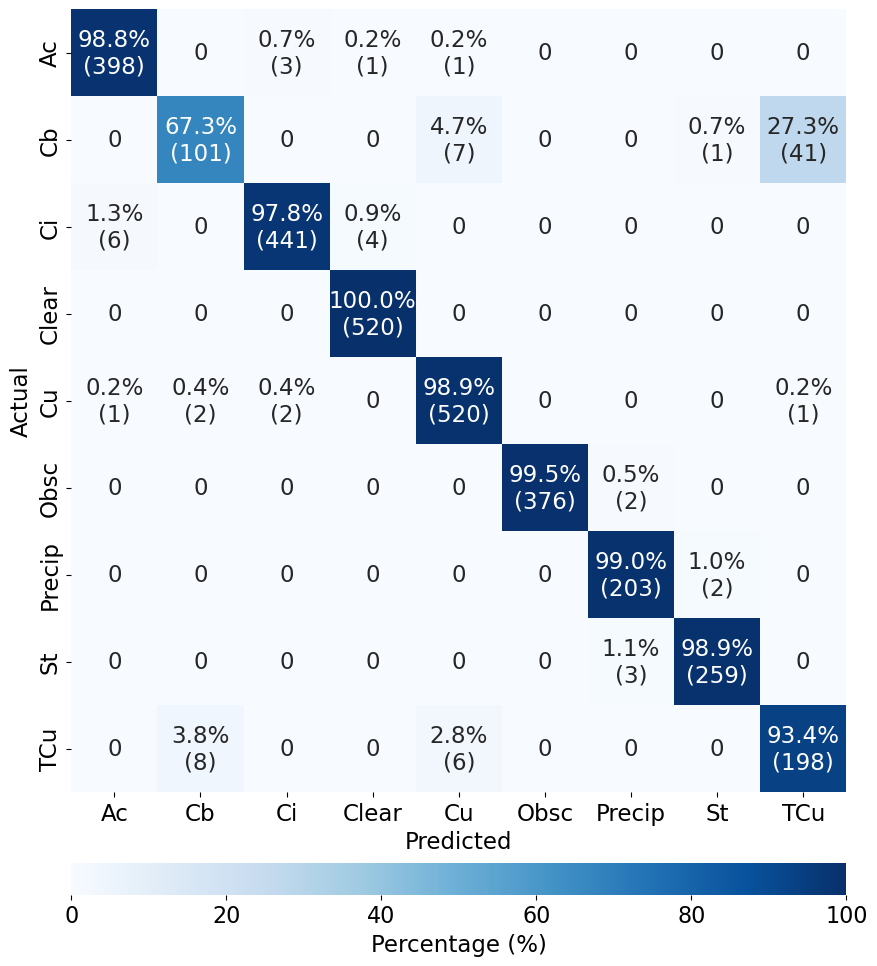

In [61]:
# Generate a confusion matrix for the ensemble model validation results
import matplotlib.gridspec as gridspec

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = cm_normalized * 100

# Create annotation strings: "85.0%\n(34)", or "0" if zero count
annotations = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] == 0:
            annotations[i, j] = "0"
        else:
            annotations[i, j] = f"{cm_percent[i, j]:.1f}%\n({cm[i, j]})"

# Custom layout with tighter control
fig = plt.figure(figsize=(10, 11.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[25, 1], hspace=0.175)  # reduce hspace to pull colorbar closer

# Main heatmap
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])  # Colorbar below

sns.heatmap(
    cm_percent,
    annot=annotations,
    fmt='',
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_ax=cbar_ax,
    cbar_kws={'orientation': 'horizontal'},
    ax=ax,
    annot_kws={"size": 16.5}  # font size for annotations
)

ax.set_xlabel('Predicted', fontsize=16.5)
ax.set_ylabel('Actual', fontsize=16.5)
ax.tick_params(axis='both', labelsize=16.5)  # axis tick labels

# Set colorbar label with fontsize
cbar_ax.set_xlabel('Percentage (%)', fontsize=16.5)

# Increase colorbar tick label font size
cbar_ax.tick_params(axis='x', labelsize=16)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [115]:
#Generate a classification report for the ensemble validation results
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

          Ac       0.98      0.99      0.99       403
          Cb       0.91      0.67      0.77       150
          Ci       0.99      0.98      0.98       451
       Clear       0.99      1.00      1.00       520
          Cu       0.97      0.99      0.98       526
        Obsc       1.00      0.99      1.00       378
      Precip       0.98      0.99      0.98       205
          St       0.99      0.99      0.99       262
         TCu       0.82      0.93      0.88       212

    accuracy                           0.97      3107
   macro avg       0.96      0.95      0.95      3107
weighted avg       0.97      0.97      0.97      3107



C:\Users\marcu\AppData\Local\Temp\ipykernel_17036\3287408785.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


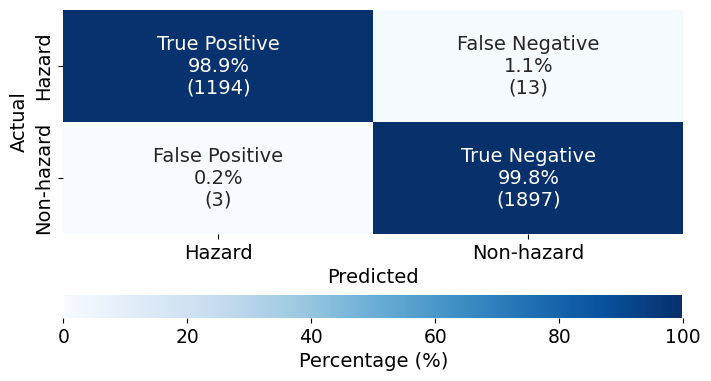

In [6]:
#Generate a binary (hazard-based) confusion matrix, see manuscript for details
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Define raw results values (these were calculated manually in a spreadsheet)
TP = 1194
FN = 13
FP = 3
TN = 1897

# Construct the confusion matrix
cm = np.array([[TP, FN],
               [FP, TN]])

# Normalize to percentages (row-wise)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = cm_normalized * 100

# Define the label names for each cell
cell_labels = np.array([["True Positive", "False Negative"],
                        ["False Positive", "True Negative"]])

# Create annotation strings with labels
annotations = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] == 0:
            annotations[i, j] = f"{cell_labels[i, j]}\n0"
        else:
            annotations[i, j] = f"{cell_labels[i, j]}\n{cm_percent[i, j]:.1f}%\n({cm[i, j]})"

# Labels
class_names2 = ['Hazard', 'Non-hazard']

# Create figure with custom layout
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1], hspace=0.5)

# Heatmap
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

sns.heatmap(
    cm_percent,
    annot=annotations,
    fmt='',
    cmap="Blues",
    xticklabels=class_names2,
    yticklabels=class_names2,
    cbar_ax=cbar_ax,
    cbar_kws={'orientation': 'horizontal'},
    ax=ax,
    annot_kws={"size": 14, "ha": "center"}
)

ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
ax.tick_params(axis='both', labelsize=14)

cbar_ax.set_xlabel('Percentage (%)', fontsize=14)
cbar_ax.tick_params(axis='x', labelsize=13.5)
cbar_ax.set_xticks([0, 20, 40, 60, 80, 100])

plt.tight_layout()
#plt.savefig('binary_confusion_matrix.png', dpi=300)
plt.show()

In [55]:
#Calculate inference time/speed (modify ensemble classification code above with a simple timer)
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

# Model definition
class InceptionV3Model(nn.Module):
    def __init__(self, num_classes=9):
        super(InceptionV3Model, self).__init__()
        self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Ensemble configuration
model_paths = [
    'inception_v3_1.pt',
    'inception_v3_2.pt',
    'inception_v3_3.pt',
    'inception_v3_4.pt',
    'inception_v3_5.pt'
]
num_classes = 9
class_names = val_dataset.classes

# Load models
models_ensemble = []
for model_path in model_paths:
    model = InceptionV3Model(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    models_ensemble.append(model)

# Validation loop with ensemble prediction and inference time tracking
all_preds = []
all_labels = []
correct_test = 0
total_test = 0

start_time = time.time()  # Start timing

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs_ensemble = torch.zeros(inputs.size(0), num_classes).to(device)
        for model in models_ensemble:
            outputs = model(inputs)
            outputs_ensemble += outputs

        outputs_ensemble /= len(models_ensemble)
        outputs_ensemble = nn.Softmax(dim=1)(outputs_ensemble)

        _, predicted = torch.max(outputs_ensemble, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()  # End timing
elapsed_time = end_time - start_time
images_per_second = total_test / elapsed_time

# Output results
ensemble_accuracy = 100 * correct_test / total_test
print(f"Ensemble Validation Accuracy: {ensemble_accuracy:.2f}%")
print(f"Inference Time: {elapsed_time:.2f} seconds")
print(f"Inference Speed: {images_per_second:.2f} images/second")

C:\Users\marcu\AppData\Local\Temp\ipykernel_8796\1014010449.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Ensemble Validation Accuracy: 97.07%
Inference Time: 178.19 seconds
Inference Speed: 17.44 images/second
